In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim.downloader as gensim_downloader
from sklearn.model_selection import train_test_split
from sklearn import metrics
import _pickle as pickle
import seaborn as sns
import tensorflow as tf
from keras.layers import Permute, Dense, multiply, Input, Embedding, Bidirectional, LSTM
from keras.models import Model


In [43]:
df = pd.read_csv("data/covid19_articles_20201231_reduced.csv")

WE_BIGRAM_PHRASER_FILEPATH = "we_bigram_phraser.pkl"
bigram_phraser = pickle.load(open(WE_BIGRAM_PHRASER_FILEPATH, "rb"))

nlp = gensim_downloader.load("word2vec-google-news-300")


In [44]:
def stratified_sample_df(df, col, n_samples, random_state=69, save=False):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state=random_state))
    df_.index = df_.index.droplevel(0)
    if save:
        df_.to_csv("processed_data/tfidf_df_random.csv")
    return df_


df = stratified_sample_df(df, "topic_area", 1250)


In [45]:
## Tokenizer taken from TensorFLow
## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()


In [46]:
MAX_LENGTH = 150
_ = []
for sen in df["content"]:
    w = sen.split()
    _.append(w)
## get bigrams
_ = list(bigram_phraser[_])
## fit tokenizer
tokenizer.fit_on_texts(_)
## create sequences
seqences = tokenizer.texts_to_sequences(_)

X = tf.keras.preprocessing.sequence.pad_sequences(
    seqences, maxlen=MAX_LENGTH, padding="post", truncating="post"
)

y = df.iloc[:, -1]

y_map = {a: b for a, b in enumerate(np.unique(y))}
y_map_reverse = {b: a for a, b in y_map.items()}
y = np.array([y_map_reverse[a] for a in y])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=69
)


In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(7000, 150)
(7000,)
(1750, 150)
(1750,)


In [48]:
## create embeddings using nlp model
we_embeddings = np.zeros((len(tokenizer.word_index) + 1, 300))
for w, i in tokenizer.word_index.items():
    try:
        we_embeddings[i] = nlp[w]
    except:
        pass


In [49]:
## Attention layer
## sampled from here https://arxiv.org/abs/1409.0473
## A useful layer to understand which parts of a long text are actually relevant
def attention_layer(inputs, neurons):
    layer = Permute((2, 1))(inputs)
    layer = Dense(neurons, activation="softmax")(layer)
    layer = Permute((2, 1), name="attention")(layer)
    layer = multiply([inputs, layer])
    return layer


In [50]:
input_layer = Input(shape=(MAX_LENGTH,))

layer = Embedding(
    input_dim=we_embeddings.shape[0],
    output_dim=we_embeddings.shape[1],
    weights=[we_embeddings],
    input_length=MAX_LENGTH,
    trainable=True,
)(input_layer)

layer = attention_layer(layer, MAX_LENGTH)

layer = Bidirectional(LSTM(units=MAX_LENGTH, dropout=0.2, return_sequences=True))(layer)
layer = Bidirectional(LSTM(units=MAX_LENGTH, dropout=0.2))(layer)

layer = Dense(64, activation="relu")(layer)
layer = Dense(32, activation="relu")(layer)

output_layer = Dense(len(df.iloc[:, -1].unique()), activation="softmax")(layer)

model = Model(input_layer, output_layer)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 150, 300)     87468000    ['input_6[0][0]']                
                                                                                                  
 permute_5 (Permute)            (None, 300, 150)     0           ['embedding_5[0][0]']            
                                                                                                  
 dense_17 (Dense)               (None, 300, 150)     22650       ['permute_5[0][0]']              
                                                                                            

In [51]:
hist = model.fit(
    x=X_train,
    y=y_train,
    batch_size=10,
    epochs=10,
    verbose=1,
    validation_split=0.2,
)


Epoch 1/10
560/560 [==============================] - 445s 784ms/step - loss: 1.9055 - accuracy: 0.1727 - val_loss: 1.6127 - val_accuracy: 0.3350
Epoch 2/10
560/560 [==============================] - 439s 784ms/step - loss: 1.2672 - accuracy: 0.5141 - val_loss: 1.1660 - val_accuracy: 0.5707
Epoch 3/10
560/560 [==============================] - 453s 810ms/step - loss: 0.6286 - accuracy: 0.7684 - val_loss: 1.1527 - val_accuracy: 0.6136
Epoch 4/10
560/560 [==============================] - 446s 797ms/step - loss: 0.2248 - accuracy: 0.9198 - val_loss: 1.4573 - val_accuracy: 0.6150
Epoch 5/10
560/560 [==============================] - 447s 798ms/step - loss: 0.0778 - accuracy: 0.9746 - val_loss: 1.8755 - val_accuracy: 0.6071
Epoch 6/10
560/560 [==============================] - 441s 787ms/step - loss: 0.0329 - accuracy: 0.9916 - val_loss: 2.1181 - val_accuracy: 0.5864
Epoch 7/10
560/560 [==============================] - 451s 805ms/step - loss: 0.0162 - accuracy: 0.9955 - val_loss: 2.5817 -

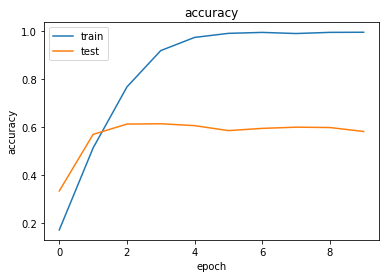

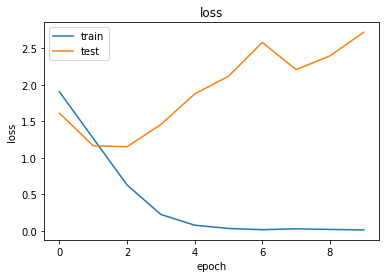

In [52]:
for x in ["accuracy", "loss"]:
    plt.plot(hist.history[x])
    plt.plot(hist.history[f"val_{x}"])
    plt.title(x)
    plt.ylabel(x)
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()


In [53]:
y_pred_prob = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred_prob]

__ = {}
for k in y_pred:
    if __.get(k) == None:
        __[k] = 0
    __[k] += 1

print(__) ## sadly model recognises all text as business

{3: 173, 1: 197, 5: 141, 6: 687, 0: 115, 4: 197, 2: 240}


In [54]:
## change back to words instead of 0-6
y_pred = [y_map[x] for x in y_pred]
y_test = [y_map[x] for x in y_test]

In [55]:
accuracy = metrics.accuracy_score(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
class_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


# Visualisations

In [56]:
print(class_report)


              precision    recall  f1-score   support

    business       0.64      0.30      0.41       250
    consumer       0.96      0.76      0.85       250
     finance       0.58      0.56      0.57       250
     general       0.69      0.48      0.56       250
  healthcare       0.88      0.69      0.77       250
     science       0.77      0.44      0.56       250
        tech       0.28      0.78      0.42       250

    accuracy                           0.57      1750
   macro avg       0.69      0.57      0.59      1750
weighted avg       0.69      0.57      0.59      1750



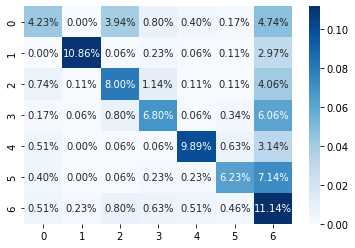

In [57]:
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix), fmt=".2%", annot=True, cmap="Blues"
)
plt.show()


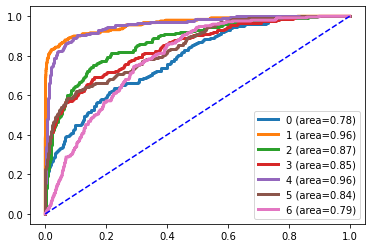

In [58]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
classes = [x for x in range(7)]
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i], y_pred_prob[:, i])
    ax.plot(
        fpr,
        tpr,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(fpr, tpr)),
    )
ax.plot([0, 1], [0, 1], color="blue", linestyle="--")
ax.legend()


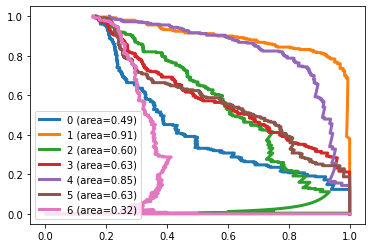

In [59]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], y_pred_prob[:, i]
    )
    ax.plot(
        precision,
        recall,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(recall, precision)),
    )
ax.legend()
